# Project Introduction:

**Introduction:**
This project aims to transform gold extraction for Zyfra by building an accurate recovery prediction model using historical data and advanced techniques, seeking to optimize operational efficiency in gold extraction processes.

**Business Problem Statement:**
The absence of a dependable predictive model hinders accurate forecasting of gold concentrate recovery, impacting resource allocation and the economic viability of extraction operations.

**Business Value:**
Accurate recovery predictions hold strategic importance, enabling optimized resource utilization, enhanced operational efficiency, and informed decision-making, thereby improving resource management and financial performance in gold extraction.


**NOTE: Details for the full project can be found in the README.md file**

## 1) Data Preparation

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading Data
full = pd.read_csv('gold_recovery_full.csv')
test = pd.read_csv('gold_recovery_test.csv')
train = pd.read_csv('gold_recovery_train.csv')

In [3]:
!pip freeze > requirements.txt

In [4]:
# General Information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
# General Information
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [6]:
# General Information
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [7]:
# Converting date from object to datetime
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d %H:%M:%S')

We need to confirm that the data for the final concentrate and rougher concentrate stages are correct.
Assuming the data in the other features are correct, we can check the validity of the rougher and final recovery concentrates by creating new rougher and final recovery concentrate features (columns) and comparing them with the given rougher and final recovery concentrate data, if the error between the given features and our features is large, we will then drop the given features and proceed with our features.



$$ \text{Recovery} = \frac{{C \times (F - T)}}{{F \times (C - T)}} \times 100\% $$

$\text{For Rougher Concentrate Recovery:}$

* $C$ (share of gold in the concentrate after flotation, rougher): rougher.output.concentrate_au

* $F$ (share of gold in the feed before flotation, rougher): rougher.input.feed_au

* $T$ (share of gold in the rougher tails right after flotation, rougher): rougher.output.tail_au

$\text{For Final Concentrate Recovery:}$

* $C$ (share of gold in the concentrate after purification, final): final.output.concentrate_au

* $F$ (share of gold in the feed in the concentrate right after flotation, final): rougher.output.concentrate_au

* $T$ (share of gold in the final tails after purification, final): final.output.tail_au

In [8]:
# Rougher Concentrate Recovery
train['rougher_target_test'] = (
    (train['rougher.output.concentrate_au']*(train['rougher.input.feed_au']-train['rougher.output.tail_au']))/
    (train['rougher.input.feed_au']*(train['rougher.output.concentrate_au']-train['rougher.output.tail_au']))) * 100

In [9]:
# Final Concentrate Recovery
train['final_target_test'] = (
    (train['final.output.concentrate_au']*(train['rougher.output.concentrate_au']-train['final.output.tail_au']))/
    (train['rougher.output.concentrate_au']*(train['final.output.concentrate_au']-train['final.output.tail_au']))) * 100

In [10]:
# Comparing the calculated recovery with the recovery in the dataset
train[['final.output.recovery','final_target_test', 'final.output.concentrate_au', 'rougher.output.concentrate_au', 'final.output.tail_au']]

,final.output.recovery,final_target_test,final.output.concentrate_au,rougher.output.concentrate_au,final.output.tail_au
0,70.541216,93.944554,42.192020,19.793808,2.143149
1,69.266198,93.790501,42.701629,20.050975,2.224930
2,68.116445,93.509750,42.657501,19.737170,2.257889
3,68.347543,93.595268,42.689819,19.320810,2.146849
4,66.927016,93.811976,42.774141,19.216101,2.055292
...,...,...,...,...,...
16855,73.755150,94.886132,46.713954,18.603550,1.529220
16856,69.049291,94.507593,46.866780,18.441436,1.612542
16857,67.002189,92.593426,46.795691,15.111231,1.596616
16858,65.523246,94.268532,46.408188,17.834772,1.602879


In [11]:
# Drop rows with missing values
train = train.dropna()

# Remove rows with infinity values in specific columns
train = train[~np.isinf(train['rougher_target_test'])]
train = train[~np.isinf(train['final_target_test'])]

# Calculate Mean Absolute Error (MAE) for rougher concentrate recovery
rougher_recovery_mae = mean_absolute_error(train['rougher_target_test'], train['rougher.output.recovery'])

# Calculate MAE for final concentrate recovery
final_recovery_mae = mean_absolute_error(train['final_target_test'], train['final.output.recovery'])

# Display MAE for rougher and final concentrate recovery
print("MAE for rougher concentrate recovery:", rougher_recovery_mae)
print("MAE for final concentrate recovery:", final_recovery_mae)


MAE for rougher concentrate recovery: 9.639512438151266e-15
MAE for final concentrate recovery: 24.19520003564495


MAE for rougher conceptrate indicates that the calculations are correct

MAE for final concentrate indicate that the calculations are incorrect

Therefore, we will use the 'final_target_test' feature for analysis and modeling

In [12]:
# Find columns present in 'train' but not in 'test'
not_common_features = [value for value in train.columns if value not in test.columns]

# Display the list of columns present in 'train' but not in 'test'
not_common_features

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [13]:
#Checking Columns
train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

The features not available in the test dataset are mostly related to the final and rougher concentrate recovery calculations, as well as some intermediate calculations and target variables. Here are the features not available in the test set.

## 2) Analysis

In [14]:
# Defining Outlier Remover Function For The Analysis
def remove_outliers_by_boxplot(data, columns, threshold=1.5):
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

### Change of the Concentration of Metals Depending on the Stage

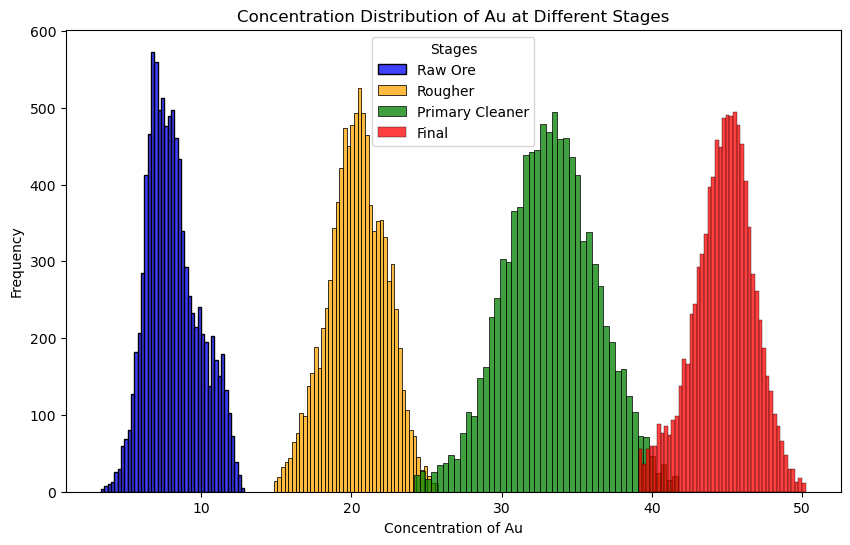

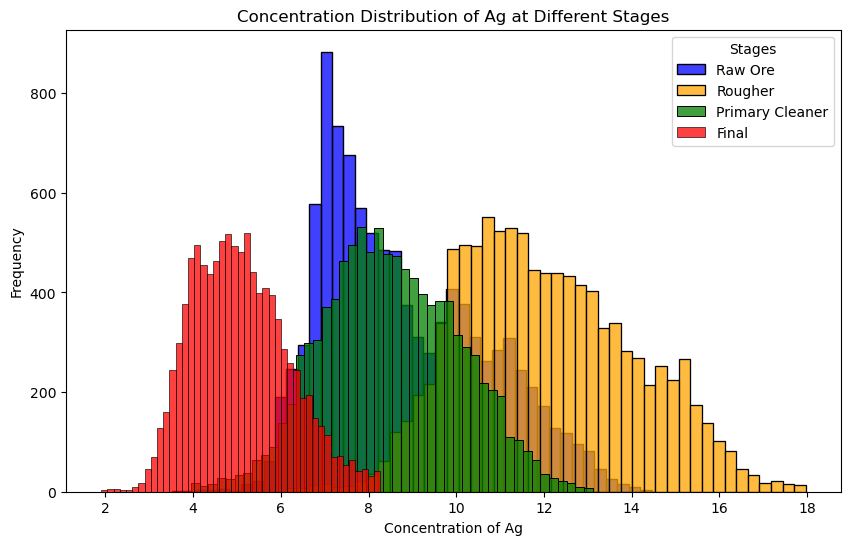

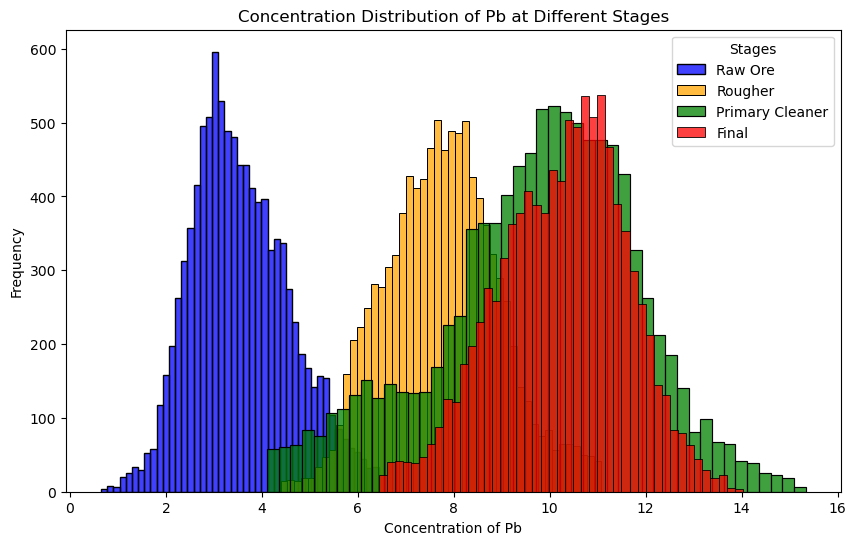

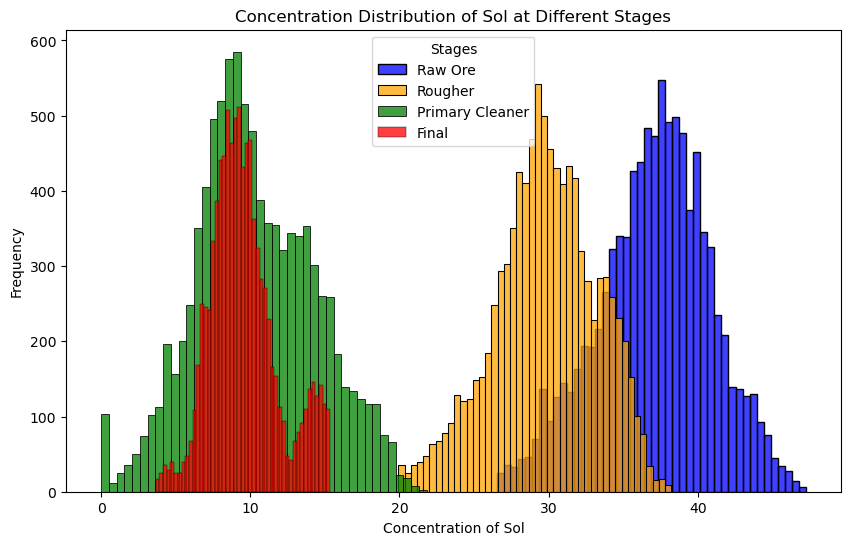

In [15]:
# Define a color palette for each stage
stage_colors = ['blue', 'orange', 'green', 'red']

# Extract the relevant columns for each substance
substances = ['au', 'ag', 'pb', 'sol']

for substance in substances:
    # Extract concentration columns for different stages
    concentrate_cols = [
        f'rougher.input.feed_{substance}',
        f'rougher.output.concentrate_{substance}',
        f'primary_cleaner.output.concentrate_{substance}',
        f'final.output.concentrate_{substance}'
    ]
    
    # Removing Potential Outliers
    full_cleaned = remove_outliers_by_boxplot(train, concentrate_cols)
    
    # Filter out rows with missing values
    concentrate_data = full_cleaned[concentrate_cols].dropna()
    
    # Create a figure and axis
    plt.figure(figsize=(10, 6))
    
    # Plot histograms for different stages using distinct colors
    for stage, col in enumerate(concentrate_cols):
        sns.histplot(data=concentrate_data, x=col, label=f'Stage {stage}', color=stage_colors[stage])
    
    # Add labels and title
    plt.xlabel(f'Concentration of {substance.capitalize()}')
    plt.ylabel('Frequency')
    plt.title(f'Concentration Distribution of {substance.capitalize()} at Different Stages')
    
    # Add a legend with stage names
    plt.legend(title='Stages', labels=['Raw Ore', 'Rougher', 'Primary Cleaner', 'Final'])
    
    # Show the plot
    plt.show()


For the concentration of Ag we can see that there is a slight increase in concentration at the rougher stage but then drastically decreases in the final stage leaving an overall lower concentration than what we started with. As for the Sol concetration we are also significantly left with lesser concentration than what we started with. However, the Pb concentration ended with higher concentration than what it started with, indicating that even though the Au concentration had the highest return (since its what the machinery is prioritizing) we may have ended with some lead (Pb) in the final gold (Au) concentration. 

### Distribution of Feed Particle Size

In [16]:
def plot_distribution(data, column_name, title, x_label):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the distribution
    sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)
    
    # Add labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel('Density')
    ax.set_title(title)
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.show()

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


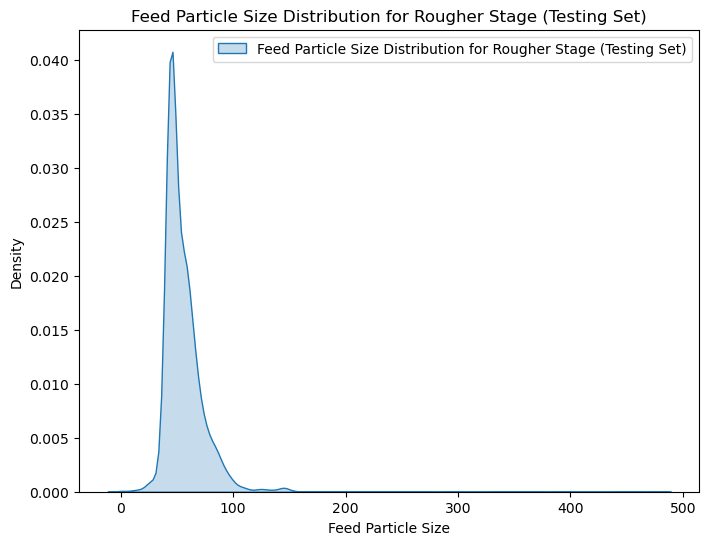

In [17]:
plot_distribution(test, 'rougher.input.feed_size', 'Feed Particle Size Distribution for Rougher Stage (Testing Set)', 'Feed Particle Size')

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


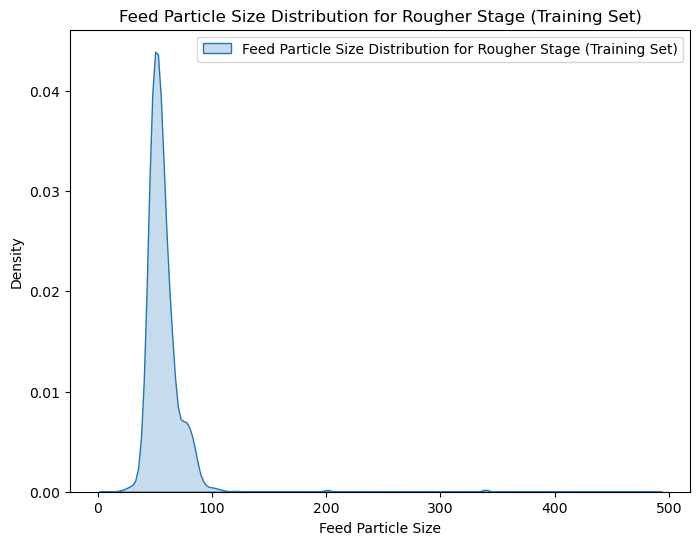

In [18]:
plot_distribution(train, 'rougher.input.feed_size', 'Feed Particle Size Distribution for Rougher Stage (Training Set)', 'Feed Particle Size')

Based on the two distributions we can observe that they have very little differences. Due to this, we can safely conclude that the model will not be significantly affected.

### Checking for Anomolies for Each Metal Depending on Stage

In [19]:
# Calculate the total for rougher input components
train['rougher_input_total'] = (
    train['rougher.input.feed_ag'] +
    train['rougher.input.feed_pb'] +
    train['rougher.input.feed_sol'] +
    train['rougher.input.feed_au']
)

# Calculate the total for rougher output components
train['rougher_output_total'] = (
    train['rougher.output.concentrate_ag'] +
    train['rougher.output.concentrate_pb'] +
    train['rougher.output.concentrate_sol'] +
    train['rougher.output.concentrate_au']
)

# Calculate the total for primary cleaner output components
train['primary_cleaner_total'] = (
    train['primary_cleaner.output.concentrate_ag'] +
    train['primary_cleaner.output.concentrate_pb'] +
    train['primary_cleaner.output.concentrate_sol'] +
    train['primary_cleaner.output.concentrate_au']
)

# Calculate the total for final output components
train['final_output_total'] = (
    train['final.output.concentrate_ag'] +
    train['final.output.concentrate_pb'] +
    train['final.output.concentrate_sol'] +
    train['final.output.concentrate_au']
)

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


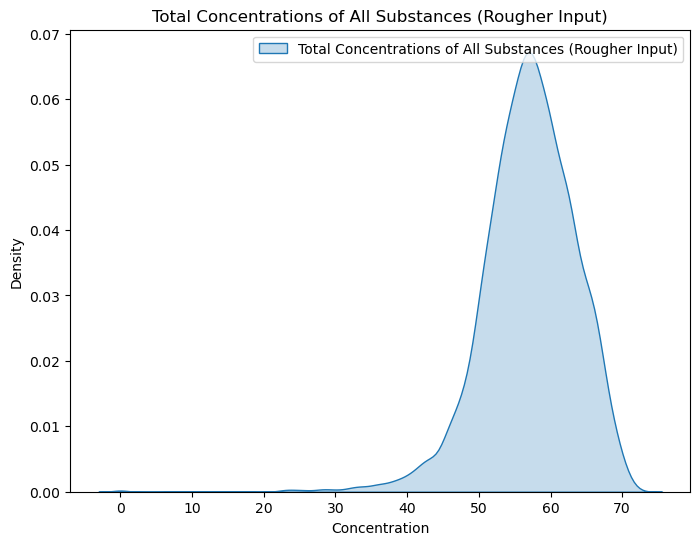

In [20]:
plot_distribution(train, 'rougher_input_total', 'Total Concentrations of All Substances (Rougher Input)', 'Concentration')

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


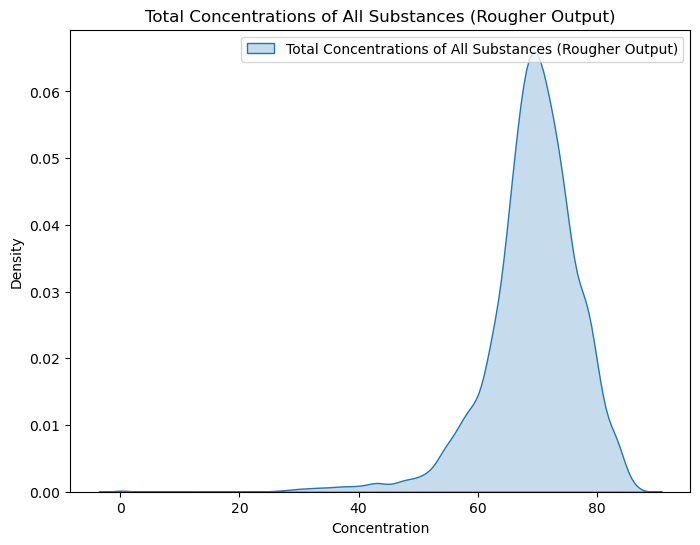

In [21]:
plot_distribution(train, 'rougher_output_total', 'Total Concentrations of All Substances (Rougher Output)', 'Concentration')

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


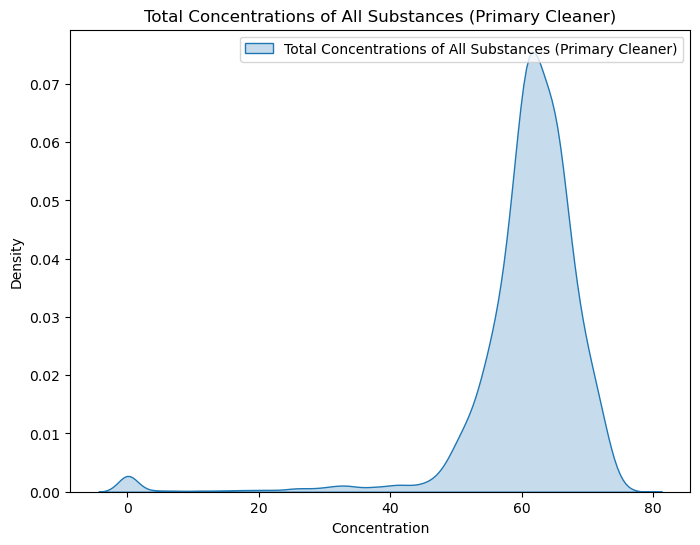

In [22]:
plot_distribution(train, 'primary_cleaner_total', 'Total Concentrations of All Substances (Primary Cleaner)', 'Concentration')

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


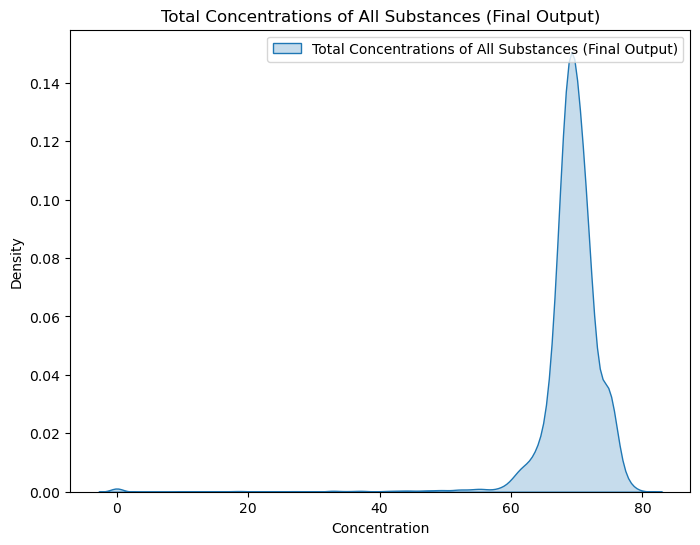

In [23]:
plot_distribution(train, 'final_output_total', 'Total Concentrations of All Substances (Final Output)', 'Concentration')

Similar to what we did when observing how the concentrations of each element change depending on the stage, we will remove the outliers to avoid any misrepresentation of the data when we proceed to modeling

In [24]:
# Columns to consider
total_columns = ['rougher_input_total', 'rougher_output_total', 'primary_cleaner_total', 'final_output_total']

# Create the total columns
train['rougher_input_total'] = train['rougher.input.feed_ag'] + train['rougher.input.feed_pb'] + train['rougher.input.feed_sol'] + train['rougher.input.feed_au']
train['rougher_output_total'] = train['rougher.output.concentrate_ag'] + train['rougher.output.concentrate_pb'] + train['rougher.output.concentrate_sol'] + train['rougher.output.concentrate_au']
train['primary_cleaner_total'] = train['primary_cleaner.output.concentrate_ag'] + train['primary_cleaner.output.concentrate_pb'] + train['primary_cleaner.output.concentrate_sol'] + train['primary_cleaner.output.concentrate_au']
train['final_output_total'] = train['final.output.concentrate_ag'] + train['final.output.concentrate_pb'] + train['final.output.concentrate_sol'] + train['final.output.concentrate_au']

# Remove outliers
train_cleaned = remove_outliers_by_boxplot(train, total_columns)

# Print the shape of the original and cleaned data
print("Original data shape:", train.shape)
print("Cleaned data shape:", train_cleaned.shape)

Original data shape: (10812, 93)
Cleaned data shape: (9480, 93)


C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


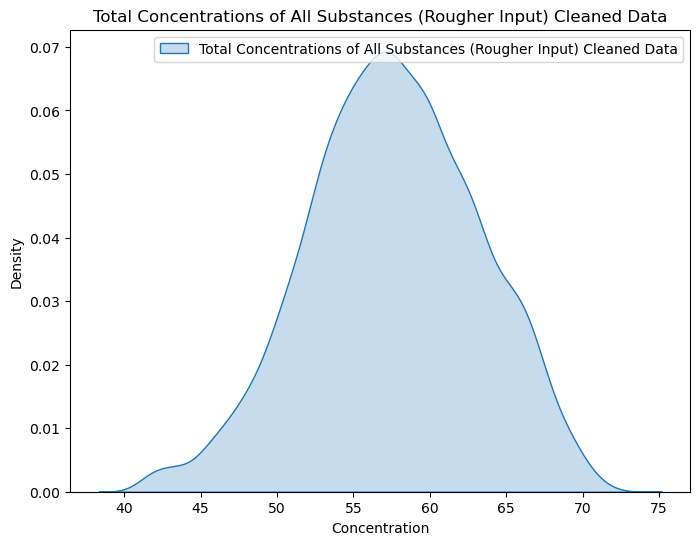

In [25]:
plot_distribution(train_cleaned, 'rougher_input_total', 'Total Concentrations of All Substances (Rougher Input) Cleaned Data', 'Concentration')

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


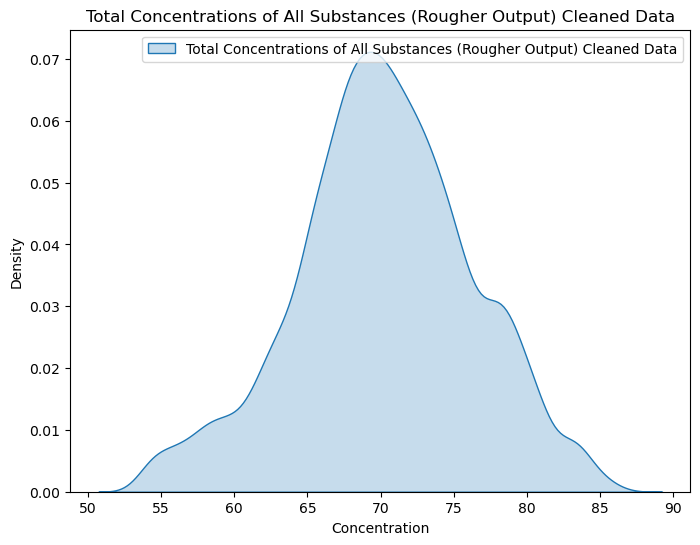

In [26]:
plot_distribution(train_cleaned, 'rougher_output_total', 'Total Concentrations of All Substances (Rougher Output) Cleaned Data', 'Concentration')

C:\Users\minec\AppData\Local\Temp\ipykernel_20684\3361876626.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[column_name], shade=True, label=title, ax=ax)


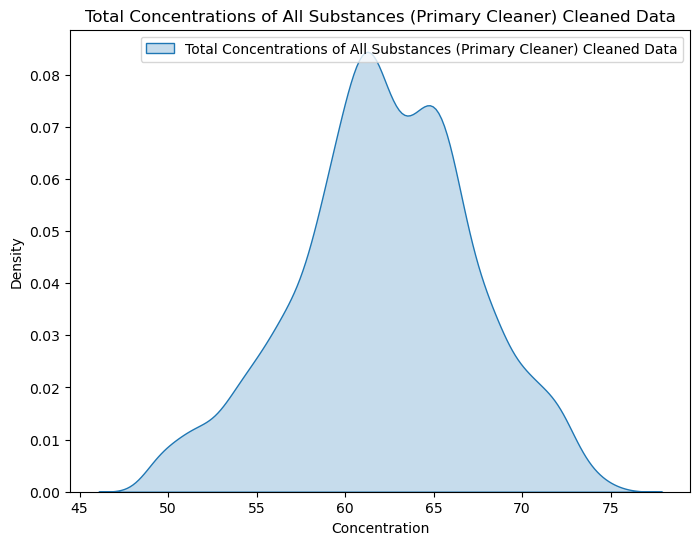

In [27]:
plot_distribution(train_cleaned, 'primary_cleaner_total', 'Total Concentrations of All Substances (Primary Cleaner) Cleaned Data', 'Concentration')

Each distribution seems to approximate towards a normal distribution, indicating that the most frequent concentration values tend towards the mean. We can also roughly approximate that 95% of the data falls between two standard deviations from the mean 

## 3) Modeling

After cleaning, analyzing, and preprocessing the data, we can now build a predictive model to forecast gold recovery concentrate to improve operational efficiency and save money.

We will use the SMAPE metric to measure our models.

In [28]:
# Define the Symmetric Mean Absolute Percentage Error (SMAPE) function
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Define the function to calculate the final SMAPE
def final_smape(smape_rougher, smape_final):
    # Calculate the weighted average of SMAPE for rougher and final stages
    return 0.25 * smape_rougher + 0.75 * smape_final

In [29]:
# Defining All Non Features To Drop

additional_non_features = ['date', 'final_output_total', 'primary_cleaner_total', 'rougher_input_total', 'rougher_output_total']

total_non_features = not_common_features + additional_non_features

In [30]:
# Define the custom sMAPE scorer for cross-validation
smape_scorer = make_scorer(smape, greater_is_better=False)

# Defining Targets & Features
X_train = train.drop(total_non_features, axis=1)
y_train_rougher = train['rougher_target_test']
y_train_final = train['final_target_test']

In [31]:
# Train different models and evaluate using cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

for model_name, model in models.items():
    
    # Cross-validation for rougher stage
    smape_rougher_cv = -cross_val_score(model, X_train, y_train_rougher, cv=5, scoring=smape_scorer)
    avg_smape_rougher = np.mean(smape_rougher_cv)
    
    # Cross-validation for final stage
    smape_final_cv = -cross_val_score(model, X_train, y_train_final, cv=5, scoring=smape_scorer)
    avg_smape_final = np.mean(smape_final_cv)
    
    # Calculate the combined final sMAPE value
    final_smape_value = final_smape(avg_smape_rougher, avg_smape_final)
    
    print(f"Model: {model_name}")
    print(f"Avg sMAPE for Rougher Stage: {avg_smape_rougher}")
    print(f"Avg sMAPE for Final Stage: {avg_smape_final}")
    print(f"Combined Final sMAPE: {final_smape_value}")
    print("-" * 40)


Model: Linear Regression
Avg sMAPE for Rougher Stage: 6.177988356114751
Avg sMAPE for Final Stage: 3.1967312125751524
Combined Final sMAPE: 3.942045498460052
----------------------------------------
Model: Random Forest
Avg sMAPE for Rougher Stage: 6.2212358584152705
Avg sMAPE for Final Stage: 4.5167111888420965
Combined Final sMAPE: 4.94284235623539
----------------------------------------


Based on these results, the Linear Regression model seems to perform better than the Random Forest Regression model.

Let's recap:

The training dataset contains all features but only approximately 50% of observations from the full dataset, which also contains all features but 100% of observations.

The test dataset does not contain all features but only those features that would appear in a realistic scenario; it contains 25% of the full dataset.

If real-life scenarios would contain all features, then we wouldn't need to create a predictive model. We would just use the recovery formulas.

Since we lack many variables from the recovery formula (the one displayed earlier), we have to create a machine-learning model that can approximate the output with the features it would have; that is what the test dataset represents.

However, we need to update the test dataset so it contains the rougher and final recovery concentrate (the targets), so that we can compare with our predictions and measure our predictive model with the SMAPE metric.

In [32]:
# Rougher Concentrate Recovery
full['rougher_target_test'] = (
    (full['rougher.output.concentrate_au']*(full['rougher.input.feed_au']-full['rougher.output.tail_au']))/
    (full['rougher.input.feed_au']*(full['rougher.output.concentrate_au']-full['rougher.output.tail_au']))) * 100

In [33]:
# Final Concentrate Recovery
full['final_target_test'] = (
    (full['final.output.concentrate_au']*(full['rougher.output.concentrate_au']-full['final.output.tail_au']))/
    (full['rougher.output.concentrate_au']*(full['final.output.concentrate_au']-full['final.output.tail_au']))) * 100

In [34]:
drop_targets = ['rougher_target_test', 'final_target_test']

# Create a set of columns to drop by removing the drop_targets
columns_drop = set(not_common_features) - set(drop_targets)

# Get the unique dates from the test dataset
test_dates = test['date'].unique()

# Filter the full dataset based on the test dates
filtered_full = full[full['date'].isin(test_dates)]

# Reset the index of the filtered DataFrame
filtered_full.reset_index(drop=True, inplace=True)

# Drop the specified columns from the filtered DataFrame to create our new updated test dataset with the targets
test_updated = filtered_full.drop(columns=columns_drop, axis=1)

In [35]:
# Create separate models for rougher and final stages
rougher_model = LinearRegression()
final_model = LinearRegression()

# Train the rougher model
rougher_model.fit(X_train, y_train_rougher)

# Train the final model
final_model.fit(X_train, y_train_final)

LinearRegression()

In [36]:
# Removing Missing Values
test_updated = test_updated.dropna()

# Preparing Features
X_test = test_updated.drop(['date', 'rougher_target_test', 'final_target_test'], axis=1)

In [37]:
# Make predictions
rougher_predictions = rougher_model.predict(X_test)
final_predictions = final_model.predict(X_test)

In [38]:
# Calculate sMAPE for the rougher predictions
rougher_smape_value = smape(test_updated['rougher_target_test'], rougher_predictions)

# Calculate sMAPE for the final predictions
final_smape_value = smape(test_updated['final_target_test'], final_predictions)

In [39]:
# Calculate custom sMAPE for the test set predictions
test_smape = final_smape(rougher_smape_value, final_smape_value)

# Create a DummyRegressor with strategy 'mean' for the baseline
dummy_regressor = DummyRegressor(strategy='mean')

# Fit the DummyRegressor on the training data
dummy_rough = dummy_regressor.fit(X_train, train['rougher_target_test'])

# Fit the DummyRegressor on the training data
dummy_final = dummy_regressor.fit(X_train, train['final_target_test'])

# Make predictions using the dummy regressor
dummy_predictions_rough = dummy_rough.predict(X_test)

# Make predictions using the dummy regressor
dummy_predictions_final = dummy_final.predict(X_test)

# Calculate sMAPE for the dummy predictions
dummy_smape_rough = smape(test_updated['rougher_target_test'], dummy_predictions_rough)
dummy_smape_final = smape(test_updated['final_target_test'], dummy_predictions_final)

# Calculate sMAPE for the final predictions of dummy
final_smape_dummy = final_smape(dummy_smape_rough, dummy_smape_final)

print(f"Baseline sMAPE on test set: {final_smape_dummy}")
print()
print(f"Custom sMAPE on test set predictions: {test_smape}")


Baseline sMAPE on test set: 5.609281705374244

Custom sMAPE on test set predictions: 5.332169162564367


The model has presented successful results compared to the sanity test

5.25% improvement from expected baseline